In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS (NGI)",
    "aviti_hq": "AVITI CB (HQ)",
    "xplus_sns": "NovaSeqX+ (S&S)",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/nfcore_sarek_rerun/multiqc/250218/multiqc_data")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2025-02-21T14:37:14.783506+01:00

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.28.0

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 24.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 11
Architecture: 64bit



In [4]:
%watermark -iv

numpy     : 2.1.1
pandas    : 2.2.3
matplotlib: 3.9.2
seaborn   : 0.13.2



## Duplication

In [6]:
dups = pd.read_csv(basedir / "multiqc_general_stats.txt", sep="\t")
dups = dups.rename(columns={"GATK4 MarkDuplicates: Mark Duplicates_mqc-generalstats-gatk4_markduplicates_mark_duplicates-PERCENT_DUPLICATION": "Percent"})
dups = dups[~dups["Percent"].isna()]
dups = dups[["Sample", "Percent"]]
dups["run"] = dups["Sample"].str.split(" | ",expand=True)[0]
dups["Data source"] = dups["run"].replace(run_names)
dups


,Sample,Percent,run,Data source
3,aviti_hq | KMS12BM-20231208_PLT-04_EBSL-0477-O...,0.009864,aviti_hq,AVITI CB (HQ)
14,aviti_hq | MM1S-20231208_PLT-04_EBSL-0478-OBPA...,0.013754,aviti_hq,AVITI CB (HQ)
24,aviti_hq | OPM2-20231208_PLT-04_EBSL-0478-OBPA...,0.011726,aviti_hq,AVITI CB (HQ)
31,aviti_hq | REH-20231208_PLT-04_EBSL-0478-OBPA_...,0.010633,aviti_hq,AVITI CB (HQ)
39,aviti_ngi | KMS12BM-B2403418436_KMS-812-5mil-D...,0.033803,aviti_ngi,AVITI CB FS (NGI)
43,aviti_ngi | MM1S-B2403418437_MM1-S-5mil-DE090-...,0.037226,aviti_ngi,AVITI CB FS (NGI)
49,aviti_ngi | OPM2-B2403418431_5mil-OPM2-DE090-1...,0.036495,aviti_ngi,AVITI CB FS (NGI)
55,aviti_ngi | REH-B2403418440_REH-wb-8-0-milj-12...,0.031682,aviti_ngi,AVITI CB FS (NGI)
66,xplus_sns | KMS12BM-L002_Sample_FU-199-KMS-812...,0.212910,xplus_sns,NovaSeqX+ (S&S)
70,xplus_sns | MM1S-L001_Sample_FU-199-MM1-S-5mil...,0.226009,xplus_sns,NovaSeqX+ (S&S)


Text(0, 0.5, '% Duplicates')

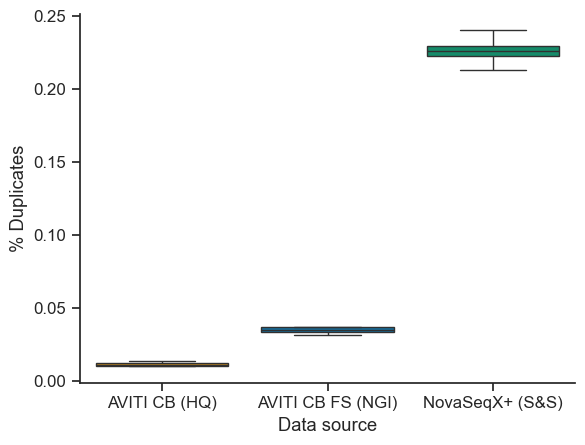

In [7]:
ax = sns.boxplot(data=dups, x="Data source", y="Percent", hue="Data source", hue_order=run_names.values())
ax.set_ylabel("% Duplicates")

In [123]:
dups.columns

Index(['Sample', 'Unique Pairs', 'Unique Unpaired', 'Duplicate Pairs Optical',
       'Duplicate Pairs Nonoptical', 'Duplicate Unpaired', 'Unmapped', 'run',
       'Data source'],
      dtype='object')

In [10]:
dups

,Sample,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE,run,cell,Data source
0,aviti_hq | KMS12BM-20231208_PLT-04_EBSL-0477-O...,KMS12BM,1089908.0,537581656.0,3943904.0,1445306.0,315420.0,5150448.0,31145.0,0.009864,2.804318e+10,aviti_hq,KMS12BM,AVITI CB (HQ)
1,aviti_hq | MM1S-20231208_PLT-04_EBSL-0478-OBPA...,MM1S,1065273.0,524109981.0,4303058.0,1386433.0,287394.0,7072139.0,33176.0,0.013754,1.933464e+10,aviti_hq,MM1S,AVITI CB (HQ)
2,aviti_hq | OPM2-20231208_PLT-04_EBSL-0478-OBPA...,OPM2,982350.0,525093543.0,3534626.0,1266060.0,237509.0,6044441.0,39792.0,0.011726,2.278031e+10,aviti_hq,OPM2,AVITI CB (HQ)
3,aviti_hq | REH-20231208_PLT-04_EBSL-0478-OBPA_...,REH,1016701.0,473635277.0,3665128.0,1325311.0,264741.0,4909100.0,25767.0,0.010633,2.280834e+10,aviti_hq,REH,AVITI CB (HQ)
4,aviti_ngi | KMS12BM-B2403418436_KMS-812-5mil-D...,KMS12BM,429479.0,189655265.0,1401922.0,546021.0,115627.0,6360345.0,545544.0,0.033803,3.011761e+09,aviti_ngi,KMS12BM,AVITI CB FS (NGI)
5,aviti_ngi | MM1S-B2403418437_MM1-S-5mil-DE090-...,MM1S,426724.0,190710750.0,1600308.0,541182.0,106573.0,7054101.0,515343.0,0.037226,2.702375e+09,aviti_ngi,MM1S,AVITI CB FS (NGI)
6,aviti_ngi | OPM2-B2403418431_5mil-OPM2-DE090-1...,OPM2,430847.0,215129027.0,1454790.0,537415.0,97660.0,7810238.0,685348.0,0.036495,3.155260e+09,aviti_ngi,OPM2,AVITI CB FS (NGI)
7,aviti_ngi | REH-B2403418440_REH-wb-8-0-milj-12...,REH,424447.0,162726662.0,1306021.0,532957.0,99459.0,5112507.0,298070.0,0.031682,2.685578e+09,aviti_ngi,REH,AVITI CB FS (NGI)
8,xplus_sns | KMS12BM-L002_Sample_FU-199-KMS-812...,KMS12BM,1632620.0,691446690.0,5450509.0,4285542.0,702838.0,147038309.0,122540863.0,0.212910,6.414841e+09,xplus_sns,KMS12BM,NovaSeqX+ (S&S)
9,xplus_sns | MM1S-L001_Sample_FU-199-MM1-S-5mil...,MM1S,1498825.0,684708661.0,5956837.0,3618779.0,658946.0,154590095.0,128076435.0,0.226009,5.655959e+09,xplus_sns,MM1S,NovaSeqX+ (S&S)


In [38]:
dups = pd.read_csv(basedir / "multiqc_picard_dups.txt", sep="\t")
dups["run"] = dups["Sample"].str.split(" | ",expand=True)[0]
dups["cell"] = dups["Sample"].str.split(" | ",expand=True)[2].str.split("-", expand=True)[0]
dups["Data source"] = dups["run"].replace(run_names)
# https://github.com/MultiQC/MultiQC/blob/main/multiqc/modules/picard/MarkDuplicates.py#L235
# dups = d["UNPAIRED_READ_DUPLICATES"] + d["READ_PAIR_DUPLICATES"] * 2
# examined = d["UNPAIRED_READS_EXAMINED"] + d["READ_PAIRS_EXAMINED"] * 2
dups["Examined"] = dups['UNPAIRED_READS_EXAMINED'] + 2 * dups['READ_PAIRS_EXAMINED']
dups["Mapped"] = dups["Examined"] - dups["UNMAPPED_READS"] 
dups["Optical duplicates"] = 100 * (2 * dups["READ_PAIR_OPTICAL_DUPLICATES"]) / dups["Mapped"]
dups["Nonoptical duplicates"] = 100 * (2 * (dups["READ_PAIR_DUPLICATES"] - dups["READ_PAIR_OPTICAL_DUPLICATES"]) + dups["UNPAIRED_READ_DUPLICATES"]) / dups["Mapped"]

dups.head()

,Sample,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE,run,cell,Data source,Examined,Mapped,Optical duplicates,Nonoptical duplicates
0,aviti_hq | KMS12BM-20231208_PLT-04_EBSL-0477-O...,KMS12BM,1089908.0,537581656.0,3943904.0,1445306.0,315420.0,5150448.0,31145.0,0.009864,2.804318e+10,aviti_hq,KMS12BM,AVITI CB (HQ),1.076253e+09,1.074808e+09,0.005795,0.981945
1,aviti_hq | MM1S-20231208_PLT-04_EBSL-0478-OBPA...,MM1S,1065273.0,524109981.0,4303058.0,1386433.0,287394.0,7072139.0,33176.0,0.013754,1.933464e+10,aviti_hq,MM1S,AVITI CB (HQ),1.049285e+09,1.047899e+09,0.006332,1.370869
2,aviti_hq | OPM2-20231208_PLT-04_EBSL-0478-OBPA...,OPM2,982350.0,525093543.0,3534626.0,1266060.0,237509.0,6044441.0,39792.0,0.011726,2.278031e+10,aviti_hq,OPM2,AVITI CB (HQ),1.051169e+09,1.049903e+09,0.007580,1.166470
3,aviti_hq | REH-20231208_PLT-04_EBSL-0478-OBPA_...,REH,1016701.0,473635277.0,3665128.0,1325311.0,264741.0,4909100.0,25767.0,0.010633,2.280834e+10,aviti_hq,REH,AVITI CB (HQ),9.482873e+08,9.469619e+08,0.005442,1.059325
4,aviti_ngi | KMS12BM-B2403418436_KMS-812-5mil-D...,KMS12BM,429479.0,189655265.0,1401922.0,546021.0,115627.0,6360345.0,545544.0,0.033803,3.011761e+09,aviti_ngi,KMS12BM,AVITI CB FS (NGI),3.797400e+08,3.791940e+08,0.287739,3.097420


In [39]:
dups.set_index(["Data source", "cell"])[["Optical duplicates", "Nonoptical duplicates"]].sort_index(ascending=False)

Optical duplicates  Nonoptical duplicates
Data source       cell                                              
NovaSeqX+ (S&S)   REH               20.533867               3.544962
                  OPM2              18.739349               3.876823
                  MM1S              18.734247               3.926451
                  KMS12BM           17.756451               3.600657
AVITI CB FS (NGI) REH                0.183233               2.990161
                  OPM2               0.318654               3.335439
                  MM1S               0.270303               3.457604
                  KMS12BM            0.287739               3.097420
AVITI CB (HQ)     REH                0.005442               1.059325
                  OPM2               0.007580               1.166470
                  MM1S               0.006332               1.370869
                  KMS12BM            0.005795               0.981945

Text(0.5, 0, '% of mapped reads')

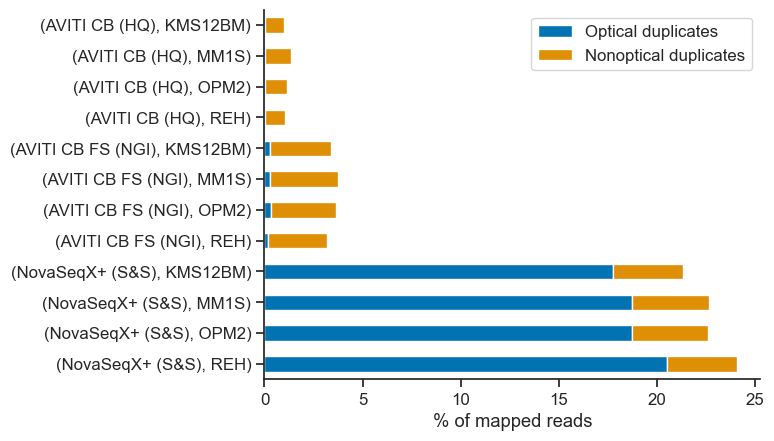

In [41]:
ax = dups.set_index(["Data source", "cell"])[["Optical duplicates", "Nonoptical duplicates"]].sort_index(ascending=False).plot.barh(stacked=True)
ax.set_ylabel(None)
ax.set_xlabel("% of mapped reads")

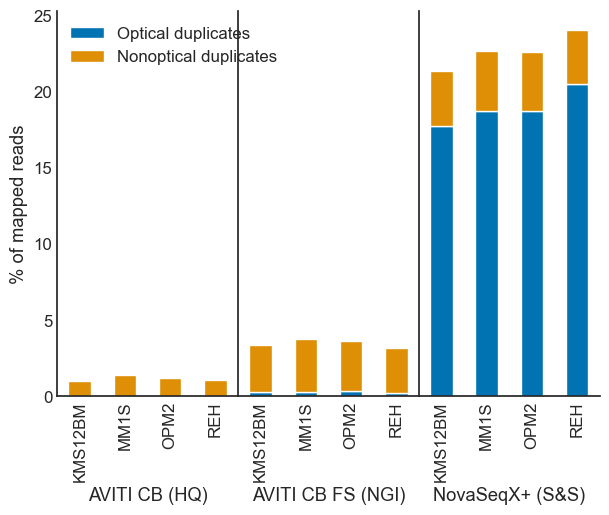

In [44]:

groups = dups.groupby("Data source")
fig, axes = plt.subplots(1, len(groups), sharex=True, sharey=True, figsize=(7,5))

for ax, (source, group) in zip(axes, groups):
    # The rename_axis function makes the difference
    group.set_index("cell").rename_axis(source)[["Optical duplicates", "Nonoptical duplicates"]].plot.bar(ax=ax, stacked=True)
    ax.tick_params(axis='both', which='both', length=0)
    ax.get_legend().remove()

fig.subplots_adjust(wspace=0)
plt.legend(bbox_to_anchor=(-0.7, 1), frameon=False, framealpha=0)
axes[0].set_ylabel("% of mapped reads")

fig = ax.get_figure()
fig.savefig(figdir / "duplicate_rates_mapped_reads.svg")

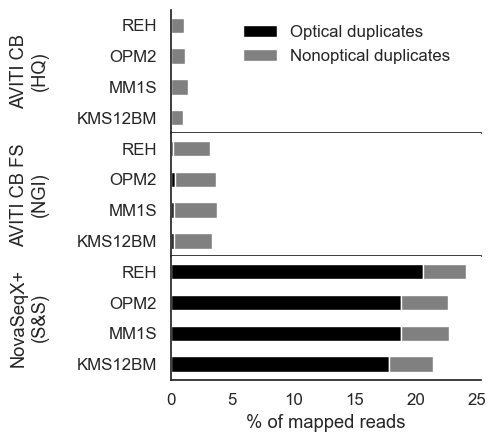

In [95]:
import textwrap
groups = dups.groupby("Data source")
fig, axes = plt.subplots(len(groups), 1, sharex=True, sharey=True, figsize=(4, 4.8))

for ax, (source, group) in zip(axes, groups):
    # The rename_axis function makes the difference
    group.set_index("cell").rename_axis(source)[
        ["Optical duplicates", "Nonoptical duplicates"]
    ].plot.barh(ax=ax, stacked=True, color={"Optical duplicates": "black", "Nonoptical duplicates": "grey"})
    ax.tick_params(axis='both', which='both', length=0, pad=10)
    ax.set_ylabel(textwrap.fill(ax.get_ylabel(), width=12), labelpad=20)
    ax.get_legend().remove()

fig.subplots_adjust(hspace=0)
axes[0].legend(bbox_to_anchor=(0.95, 1), frameon=False, framealpha=0, loc="upper right")
axes[-1].set_xlabel("% of mapped reads")
fig = ax.get_figure()
fig.savefig(figdir / "duplicate_rates_mapped_reads_h.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')
